In [1]:
from keras.models import Sequential, load_model
from keras.layers import *
from keras import optimizers, Model
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, Callback

# telegram
import telegram

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

import tensorflow as tf

# Importing matplotlib to plot images.
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import numpy as np
%matplotlib inline

# Importing SK-learn to calculate precision and recall
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneGroupOut
from sklearn.utils import shuffle 

# Used for graph export
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io
from keras import backend as K

import pickle as pkl
import h5py

from pathlib import Path
import os.path
import os
import sys
import datetime
import time
import math

Using TensorFlow backend.


# change model name to match model you want to predict with

In [2]:
model_name = "IMU_N5X_20190123_181046.1000-220034.04.h5"
smartphone = model_name.split("_")[1]

directory = str(Path.home()) + "/data/plots/" + model_name.split(".")[0]

if not os.path.exists(directory):
    print("Making directory: " + directory)
    os.makedirs(directory)

### Read dataframe containing all information

In [3]:
df = pd.read_pickle("../../data/new-by-sven.pkl")
df = df[(df.Phone == smartphone)]

df.XTouch = df.XTouch * 1080
df.YTouch = df.YTouch * 1920

df.Input = df.Input.apply(lambda x: x.reshape(-1, 18, 1))
df.Input = df.Input.apply(lambda x: x[:,:6])

np.random.seed(42)
lst = df.Participant.unique()
np.random.shuffle(lst)

shape = df.Input.iloc[0].shape

dfTrain = df[df.Participant.isin(lst[:14])]
dfTest = df[df.Participant.isin(lst[14:])]

train_x = np.concatenate(dfTrain.Input.values).reshape(-1, shape[0], shape[1], shape[2])
train_y = dfTrain[['XTouch', 'YTouch']].values
train_x = np.concatenate([train_x,train_x,train_x,train_x])
train_y = np.concatenate([train_y,train_y,train_y,train_y])

test_x = np.concatenate(dfTest.Input.values).reshape(-1, shape[0], shape[1], shape[2])
test_y = dfTest[['XTouch', 'YTouch']].values

In [4]:
window_size = 50
batch_size = 100

# set screen resolution and pixel size constant (mm)
if smartphone == "N5X":
    pixels = {"width": 1080, "height": 1920}
    constant_pixels = 0.06
elif smartphone == "S3Mini":
    pixels = {"width": 480, "height": 800}
    constant_pixels = 0.1089
elif smartphone == "S4":
    pixels = {"width": 1080, "height": 1920}
    constant_pixels = 0.0577
elif smartphone == "N6":
    pixels = {"width": 1440, "height": 2560}
    constant_pixels = 0.05109
    
#HDF5_PATH = str(Path.home()) + "/data/hdf-acc/" + smartphone + "-win" + str(window_size) + ".hdf"

# Predict on both training and test data

In [5]:
%%time

model_path = str(Path.home()) + "/data/models/" + model_name

with tf.device('/device:GPU:0'):
    config = tf.ConfigProto(log_device_placement = True, allow_soft_placement = True)
    config.gpu_options.allow_growth = True
    config.gpu_options.per_process_gpu_memory_fraction = 0.3
    config.gpu_options.allocator_type = 'BFC'
    
    with tf.Session(config=config):
        tf.get_default_graph()
        
        ### metrics for evaluation
        def eucInMM(y_true, y_pred):
            return (K.sqrt(K.sum(K.square(y_true - y_pred), axis=-1, keepdims=True))) * constant_pixels
        def euc(y_true, y_pred):
            return K.sqrt(K.sum(K.square(y_true - y_pred), axis=-1, keepdims=True))
        def eucStdMM(y_true, y_pred):
            return K.std(K.sqrt(K.sum(K.square(y_true - y_pred), axis=-1))) * constant_pixels
        def rmse(y_true, y_pred):
            return K.sqrt(K.mean(K.square(y_true - y_pred)))
        
        model = load_model(model_path, custom_objects={'eucInMM': eucInMM, 'eucStdMM': eucStdMM, 'euc':euc, 'rmse':rmse})

        optimizer = optimizers.Adam(lr = 0.001, decay = 1e-6)
        model.compile(loss = 'mse', optimizer = optimizer, metrics = ['mae', euc, eucInMM, rmse])
        ###Feed generator into compiled network: either myGenerator("test", batch_size) or myGenerator("train", batch_size)
        ###Adapt steps to either len(test_x) // batch_size or len(train_x) // batch_size
        #hist = model.predict_generator(myGenerator("test", batch_size), steps = len(test_x) // batch_size)
        hist_test = model.predict(test_x, batch_size=batch_size, verbose=0, steps=None)
        hist_train = model.predict(train_x, batch_size=batch_size, verbose=0, steps=None)

CPU times: user 5.33 s, sys: 1.2 s, total: 6.53 s
Wall time: 6.26 s


### Create df from predicted and true points, scale points back to phone coordinates

In [6]:
df_train = pd.DataFrame(np.concatenate([hist_train, train_y[:len(hist_train)]], axis = 1), columns = ["XPred","YPred", "X", "Y"])
df_test = pd.DataFrame(np.concatenate([hist_test, test_y[:len(hist_test)]], axis = 1), columns = ["XPred","YPred", "X", "Y"])

In [7]:
df_train.XPred = df_train.XPred.astype(int)
df_train.YPred = df_train.YPred.astype(int)
df_train.X = df_train.X.astype(int)
df_train.Y = df_train.Y.astype(int)

df_test.XPred = df_test.XPred.astype(int)
df_test.YPred = df_test.YPred.astype(int)
df_test.X = df_test.X.astype(int)
df_test.Y = df_test.Y.astype(int)

## Plot origin plot, move true points to origin and move respective predicited points in the same order.

In [8]:
##################################################################
### Change write_string to match what you want to print into plot#
##################################################################

write_string = smartphone + "\nAcc and Gyro"

#############################################################

export_path = str(Path.home())+"/data/plots/"+ model_name.split(".")[0]

# Plots for test data

## Test Origin Plot

Exporting test origin plot to: /home/beneste/data/plots/IMU_N5X_20190123_181046
CPU times: user 1.52 s, sys: 1.29 s, total: 2.81 s
Wall time: 1.2 s


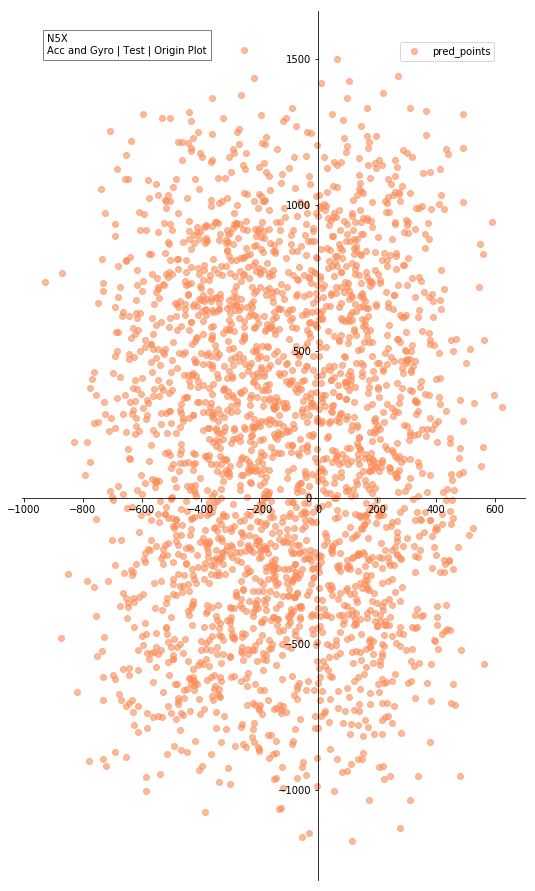

In [9]:
%%time
    
fig, ax = plt.subplots(figsize = (9,16))
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_position(('data',0))
ax.spines['bottom'].set_position(('data',0))

df_test["x_val"] = df_test.XPred - df_test.X
df_test["y_val"] = df_test.YPred - df_test.Y
ax.scatter(df_test.x_val, -df_test.y_val, c = '#fc8d59', alpha = 0.6, label = 'pred_points', marker = 'o')

plt.annotate(write_string + " | Test | Origin Plot", xy = (0.05, 0.95), 
             bbox = dict(facecolor = 'white', alpha = 0.5), xycoords = 'axes fraction')
plt.legend(bbox_to_anchor = (0.95,0.97), ncol = 1)

print("Exporting test origin plot to: " + export_path)
fig.savefig(export_path + "/test_origin_" + model_name.split(".")[0] + ".pdf", bbox_inches = "tight")
fig.savefig(export_path + "/test_origin_" + model_name.split(".")[0], bbox_inches = "tight")

## Test Prediction Plot

Exporting test predicition plot to: /home/beneste/data/plots/IMU_N5X_20190123_181046
CPU times: user 2.58 s, sys: 907 ms, total: 3.49 s
Wall time: 2.32 s


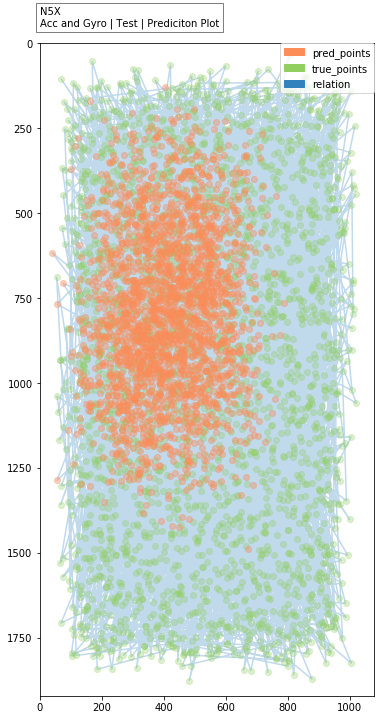

In [10]:
%%time

#patches generation for plot legend
colors = ['#fc8d59','#91cf60','#3182bd']
labels = ['pred_points','true_points','relation']
patches = []
for i in range(len(colors)):
    patch = mpatches.Patch(color=colors[i], label=labels[i])
    patches.append(patch)


fig, ax = plt.subplots(figsize = (6,12))
ax.set_xlim(0, pixels["width"])
ax.set_ylim(pixels["height"], 0)

ax.scatter(df_test.XPred.values, df_test.YPred.values, c = '#fc8d59', alpha = 0.4, zorder = 1)

ax.scatter(df_test.X.values, df_test.Y.values, c = '#91cf60', alpha = 0.3, zorder = 0.5)

l = mlines.Line2D([df_test.X.values, df_test.XPred.values], [df_test.Y.values, df_test.YPred.values], 
                  c = '#3182bd', alpha = 0.3,  zorder = -1)

ax.add_line(l)

ax.text(0, -50, write_string + " | Test | Prediciton Plot", bbox = dict(facecolor = 'white', alpha = 0.5))
plt.legend(loc = 'upper right', handles = patches, ncol = 1,  borderaxespad = 0.)


print("Exporting test predicition plot to: " + export_path)
fig.savefig(export_path + "/test_pred_" + model_name.split(".")[0] + ".pdf", bbox_inches = "tight")
fig.savefig(export_path + "/test_pred_" + model_name.split(".")[0], bbox_inches = "tight")

### Add new rows to test_df, describe test_df (mean,std,quartiles)

In [11]:
%%time
def calculate_euc(row):
    return math.sqrt((row['XPred'] - row['X'])**2 + (row['YPred'] - row['Y'])**2)

def calculate_eucMM(row):
    return row['euc'] * constant_pixels
    
def calculate_x_error(row):
    return abs(row["XPred"] - row["X"])

def calculate_y_error(row):
    return abs(row["YPred"] - row["Y"])

print("Calculating euclidean distance.")
df_test['euc'] = df_test.apply(calculate_euc, axis = 1)

print("Calculating euclidean distance in mm.")
df_test['eucMM'] = df_test.apply(calculate_eucMM, axis = 1)

print("Calculating error in x-direction.")
df_test['x_err'] = df_test.apply(calculate_x_error, axis = 1)

print("Calculating error in y-direction.")
df_test['y_err'] = df_test.apply(calculate_y_error, axis = 1)

csv_path = str(Path.home())+"/data/plots/"+model_name.split(".")[0] + "/test_" + model_name.split(".")[0] + ".csv"
print("Writing test_csv to: " + csv_path)
df_test.to_csv(csv_path, header = True)

Calculating euclidean distance.
Calculating euclidean distance in mm.
Calculating error in x-direction.
Calculating error in y-direction.
Writing test_csv to: /home/beneste/data/plots/IMU_N5X_20190123_181046/test_IMU_N5X_20190123_181046.csv
CPU times: user 572 ms, sys: 0 ns, total: 572 ms
Wall time: 572 ms


In [12]:
df_test.describe()

,XPred,YPred,X,Y,x_val,y_val,euc,eucMM,x_err,y_err
count,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000
mean,414.763889,792.075231,540.422454,962.688657,-125.658565,-170.613426,596.552616,35.793157,268.241127,485.206019
std,133.031805,240.464160,263.833429,504.182416,298.164937,553.821445,290.730963,17.443858,180.879591,316.737471
min,41.000000,128.000000,55.000000,35.000000,-928.000000,-1529.000000,28.301943,1.698117,0.000000,1.000000
25%,316.000000,616.000000,310.000000,523.000000,-356.000000,-620.250000,367.150174,22.029010,125.750000,223.000000
50%,414.000000,802.500000,539.000000,957.000000,-137.500000,-174.500000,565.636263,33.938176,237.500000,440.500000
75%,515.250000,969.000000,776.000000,1410.000000,115.000000,256.750000,791.708270,47.502496,385.250000,706.250000
max,787.000000,1489.000000,1022.000000,1875.000000,623.000000,1173.000000,1549.627375,92.977642,928.000000,1529.000000


# Training Plots

## Train Origin Plot

Exporting train origin plot to: /home/beneste/data/plots/IMU_N5X_20190123_181046
CPU times: user 4.99 s, sys: 1.03 s, total: 6.03 s
Wall time: 4.86 s


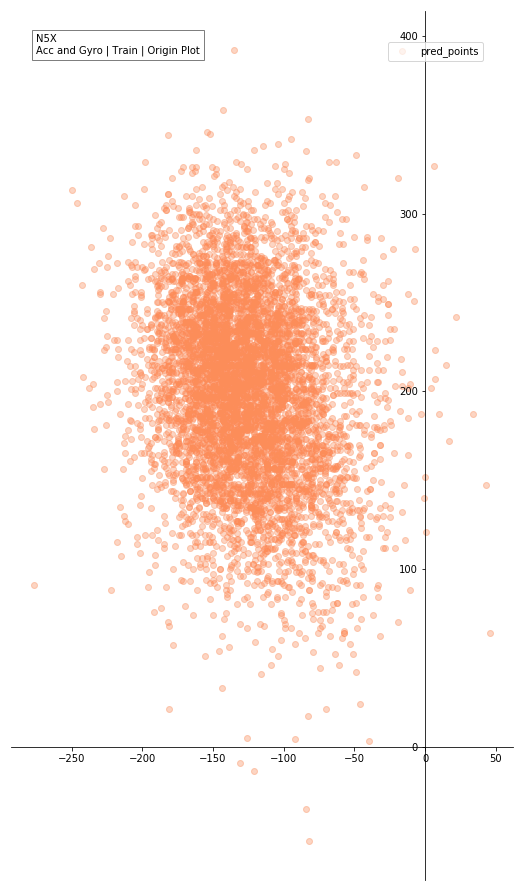

In [13]:
%%time
    
fig, ax = plt.subplots(figsize = (9,16))
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_position(('data',0))
ax.spines['bottom'].set_position(('data',0))

df_train["x_val"] = df_train.XPred - df_train.X
df_train["y_val"] = df_train.YPred - df_train.Y
ax.scatter(df_train.x_val, -df_train.y_val, c = '#fc8d59', alpha = 0.1, label = 'pred_points', marker = 'o')

plt.annotate(write_string + " | Train | Origin Plot", xy = (0.05, 0.95), bbox = dict(facecolor = 'white', alpha = 0.5), xycoords = 'axes fraction')
#ax.text(-1000, 2200,  write_string + " | Origin Plot", bbox=dict(facecolor='white', alpha=0.5))
plt.legend(bbox_to_anchor = (0.95,0.97), ncol = 1)

print("Exporting train origin plot to: " + export_path)
fig.savefig(export_path + "/train_origin_" + model_name.split(".")[0] + ".pdf", bbox_inches = "tight")
fig.savefig(export_path + "/train_origin_" + model_name.split(".")[0], bbox_inches = "tight")

## Train Prediction Plot

Exporting train predicition plot to: /home/beneste/data/plots/IMU_N5X_20190123_181046
CPU times: user 26.7 s, sys: 2.78 s, total: 29.5 s
Wall time: 28.2 s


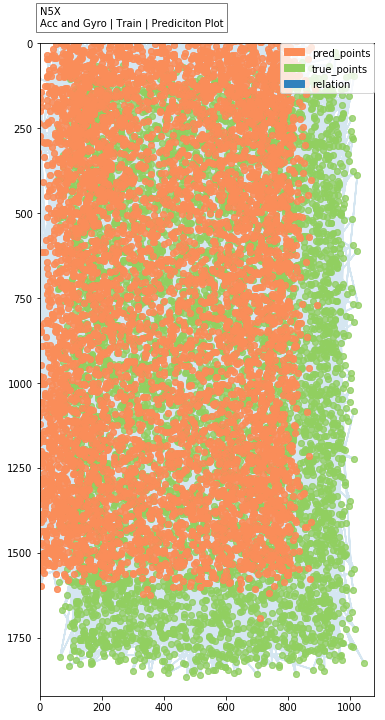

In [14]:
%%time

fig, ax = plt.subplots(figsize = (6,12))
ax.set_xlim(0, pixels["width"])
ax.set_ylim(pixels["height"], 0)

ax.scatter(df_train.XPred.values,df_train.YPred.values, c = '#fc8d59', alpha = 0.4, zorder = 1)
ax.scatter(df_train.X.values, df_train.Y.values, c = '#91cf60', alpha = 0.3, zorder = 0.5)
l = mlines.Line2D([df_train.X.values,df_train.XPred.values], [df_train.Y.values,df_train.YPred.values], 
                  c = '#3182bd', alpha = 0.2,  zorder = -1)   
ax.add_line(l)

ax.text(0, -50, write_string + " | Train | Prediciton Plot", bbox = dict(facecolor='white', alpha = 0.5))
plt.legend(loc = 'upper right', handles = patches, ncol = 1,  borderaxespad = 0.)


print("Exporting train predicition plot to: " + export_path)
fig.savefig(export_path + "/train_pred_" + model_name.split(".")[0] + ".pdf", bbox_inches = "tight")
fig.savefig(export_path + "/train_pred_" + model_name.split(".")[0], bbox_inches = "tight")

### Add new rows to train_df, describe train_df (mean,std,quartiles)

In [15]:
%%time
print("Calculating euclidean distance.")
df_train['euc'] = df_train.apply(calculate_euc, axis = 1)

print("Calculating euclidean distance in mm.")
df_train['eucMM'] = df_train.apply(calculate_eucMM, axis = 1)

print("Calculating error in x-direction.")
df_train['x_err'] = df_train.apply(calculate_x_error, axis = 1)

print("Calculating error in y-direction.")
df_train['y_err'] = df_train.apply(calculate_y_error, axis = 1)

csv_path = str(Path.home())+"/data/plots/"+model_name.split(".")[0] + "/train_" + model_name.split(".")[0] + ".csv"
print("Writing train_csv to: " + csv_path)
df_test.to_csv(csv_path, header = True)

Calculating euclidean distance.
Calculating euclidean distance in mm.
Calculating error in x-direction.
Calculating error in y-direction.
Writing train_csv to: /home/beneste/data/plots/IMU_N5X_20190123_181046/train_IMU_N5X_20190123_181046.csv
CPU times: user 4.73 s, sys: 51.8 ms, total: 4.78 s
Wall time: 4.77 s


In [16]:
df_train.describe()

,XPred,YPred,X,Y,x_val,y_val,euc,eucMM,x_err,y_err
count,24192.000000,24192.000000,24192.000000,24192.000000,24192.000000,24192.000000,24192.000000,24192.000000,24192.000000,24192.000000
mean,412.955026,764.730820,539.086310,965.298611,-126.131283,-200.567791,240.148217,14.408893,126.201389,200.604497
std,256.874641,489.831281,265.689977,503.324196,37.935861,51.644508,50.710891,3.042653,37.701974,51.501739
min,-75.000000,-110.000000,33.000000,14.000000,-277.000000,-392.000000,40.112342,2.406741,0.000000,3.000000
25%,170.000000,308.000000,302.000000,526.000000,-152.000000,-236.000000,206.717800,12.403068,102.000000,166.000000
50%,415.500000,762.000000,540.000000,960.500000,-128.000000,-203.000000,243.209785,14.592587,128.000000,203.000000
75%,654.250000,1218.250000,776.000000,1408.250000,-102.000000,-166.000000,275.448270,16.526896,152.000000,236.000000
max,895.000000,1691.000000,1046.000000,1866.000000,46.000000,53.000000,414.594983,24.875699,277.000000,392.000000


# Origin Plot for both test and train predicitions

Exporting double origin plot to: /home/beneste/data/plots/IMU_N5X_20190123_181046
CPU times: user 5.54 s, sys: 919 ms, total: 6.46 s
Wall time: 5.26 s


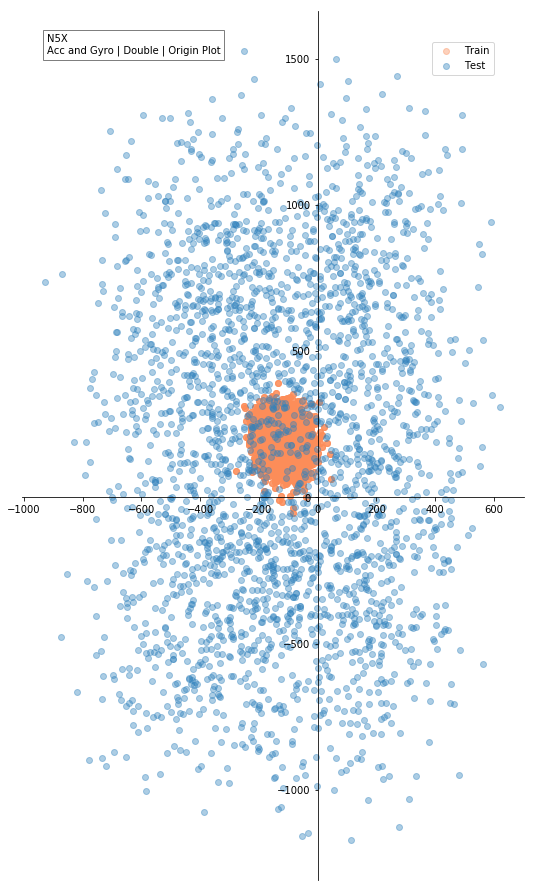

In [17]:
%%time
    
fig, ax = plt.subplots(figsize = (9,16))
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_position(('data',0))
ax.spines['bottom'].set_position(('data',0))

df_train["x_val"] = df_train.XPred - df_train.X
df_train["y_val"] = df_train.YPred - df_train.Y
ax.scatter(df_train.x_val, -df_train.y_val, c = '#fc8d59', alpha = 0.4, marker='o', label = 'Train')

df_test["x_val"] = df_test.XPred - df_test.X
df_test["y_val"] = df_test.YPred - df_test.Y
ax.scatter(df_test.x_val, -df_test.y_val, c = '#3182bd', alpha = 0.4, marker='o', label = 'Test')

plt.annotate(write_string + " | Double | Origin Plot", xy = (0.05, 0.95), bbox = dict(facecolor = 'white', alpha = 0.5), xycoords = 'axes fraction')
#ax.text(-1000, 2200,  write_string + " | Origin Plot", bbox=dict(facecolor='white', alpha=0.5))
plt.legend(bbox_to_anchor = (0.95,0.97), ncol = 1)

print("Exporting double origin plot to: " + export_path)
fig.savefig(export_path + "/double_origin_" + model_name.split(".")[0] + ".pdf", bbox_inches = "tight")
fig.savefig(export_path + "/double_origin_" + model_name.split(".")[0], bbox_inches = "tight")